In [129]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import warnings
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
warnings.filterwarnings('ignore')

filepath = '/Users/manuelaldg/Desktop/APPUNTI MATTEO/4. Cose utili/WORKS/Electricity/AUelectricyty.csv'
df = pd.read_csv(filepath)
df.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [80]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [81]:
print(f'Whole df dimension: {df.shape}')
print(f'Train df dimension: {train.shape}')
print(f'Test df dimension: {test.shape}')

Whole df dimension: (2106, 14)
Train df dimension: (1474, 14)
Test df dimension: (632, 14)


In [82]:
print(df['RRP'].dtype)

float64


In [83]:
prices = []
for i in df['RRP']:
    prices.append(i)

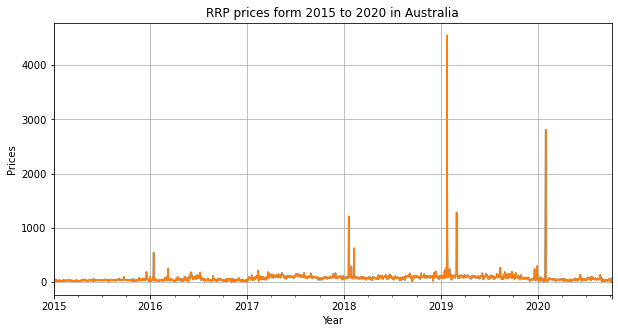

In [305]:
data_range = pd.date_range(start = train['date'].min(), end = train['date'].max())
serie = pd.Series(data = prices, index = data_range)

serie.plot(figsize=(10, 5))
serie.plot(title="RRP prices form 2015 to 2020 in Australia")
plt.xlabel("Year")
plt.ylabel("Prices")
plt.grid(True)
plt.show()

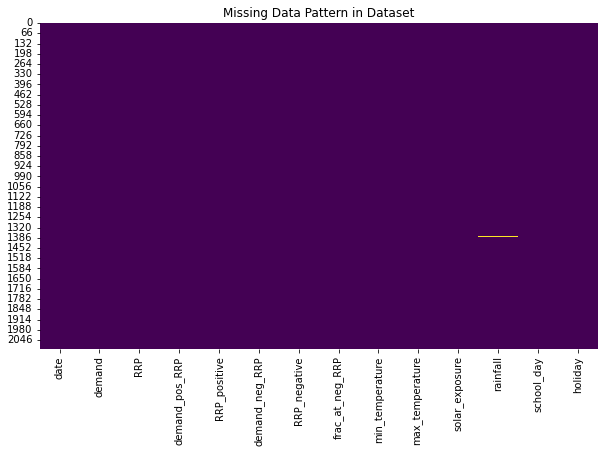

In [85]:
# Controlliamo i missing

missing_values = train.isnull().sum()

plt.figure(figsize=(10, 6))
plt.title('Missing Data Pattern in Dataset')
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [86]:
train['rainfall'].fillna(train['rainfall'].median(), inplace=True)
train['solar_exposure'].fillna(train['solar_exposure'].median(), inplace=True)

print("\nMissing values after imputation:")
print(train.isnull().sum())


Missing values after imputation:
date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64


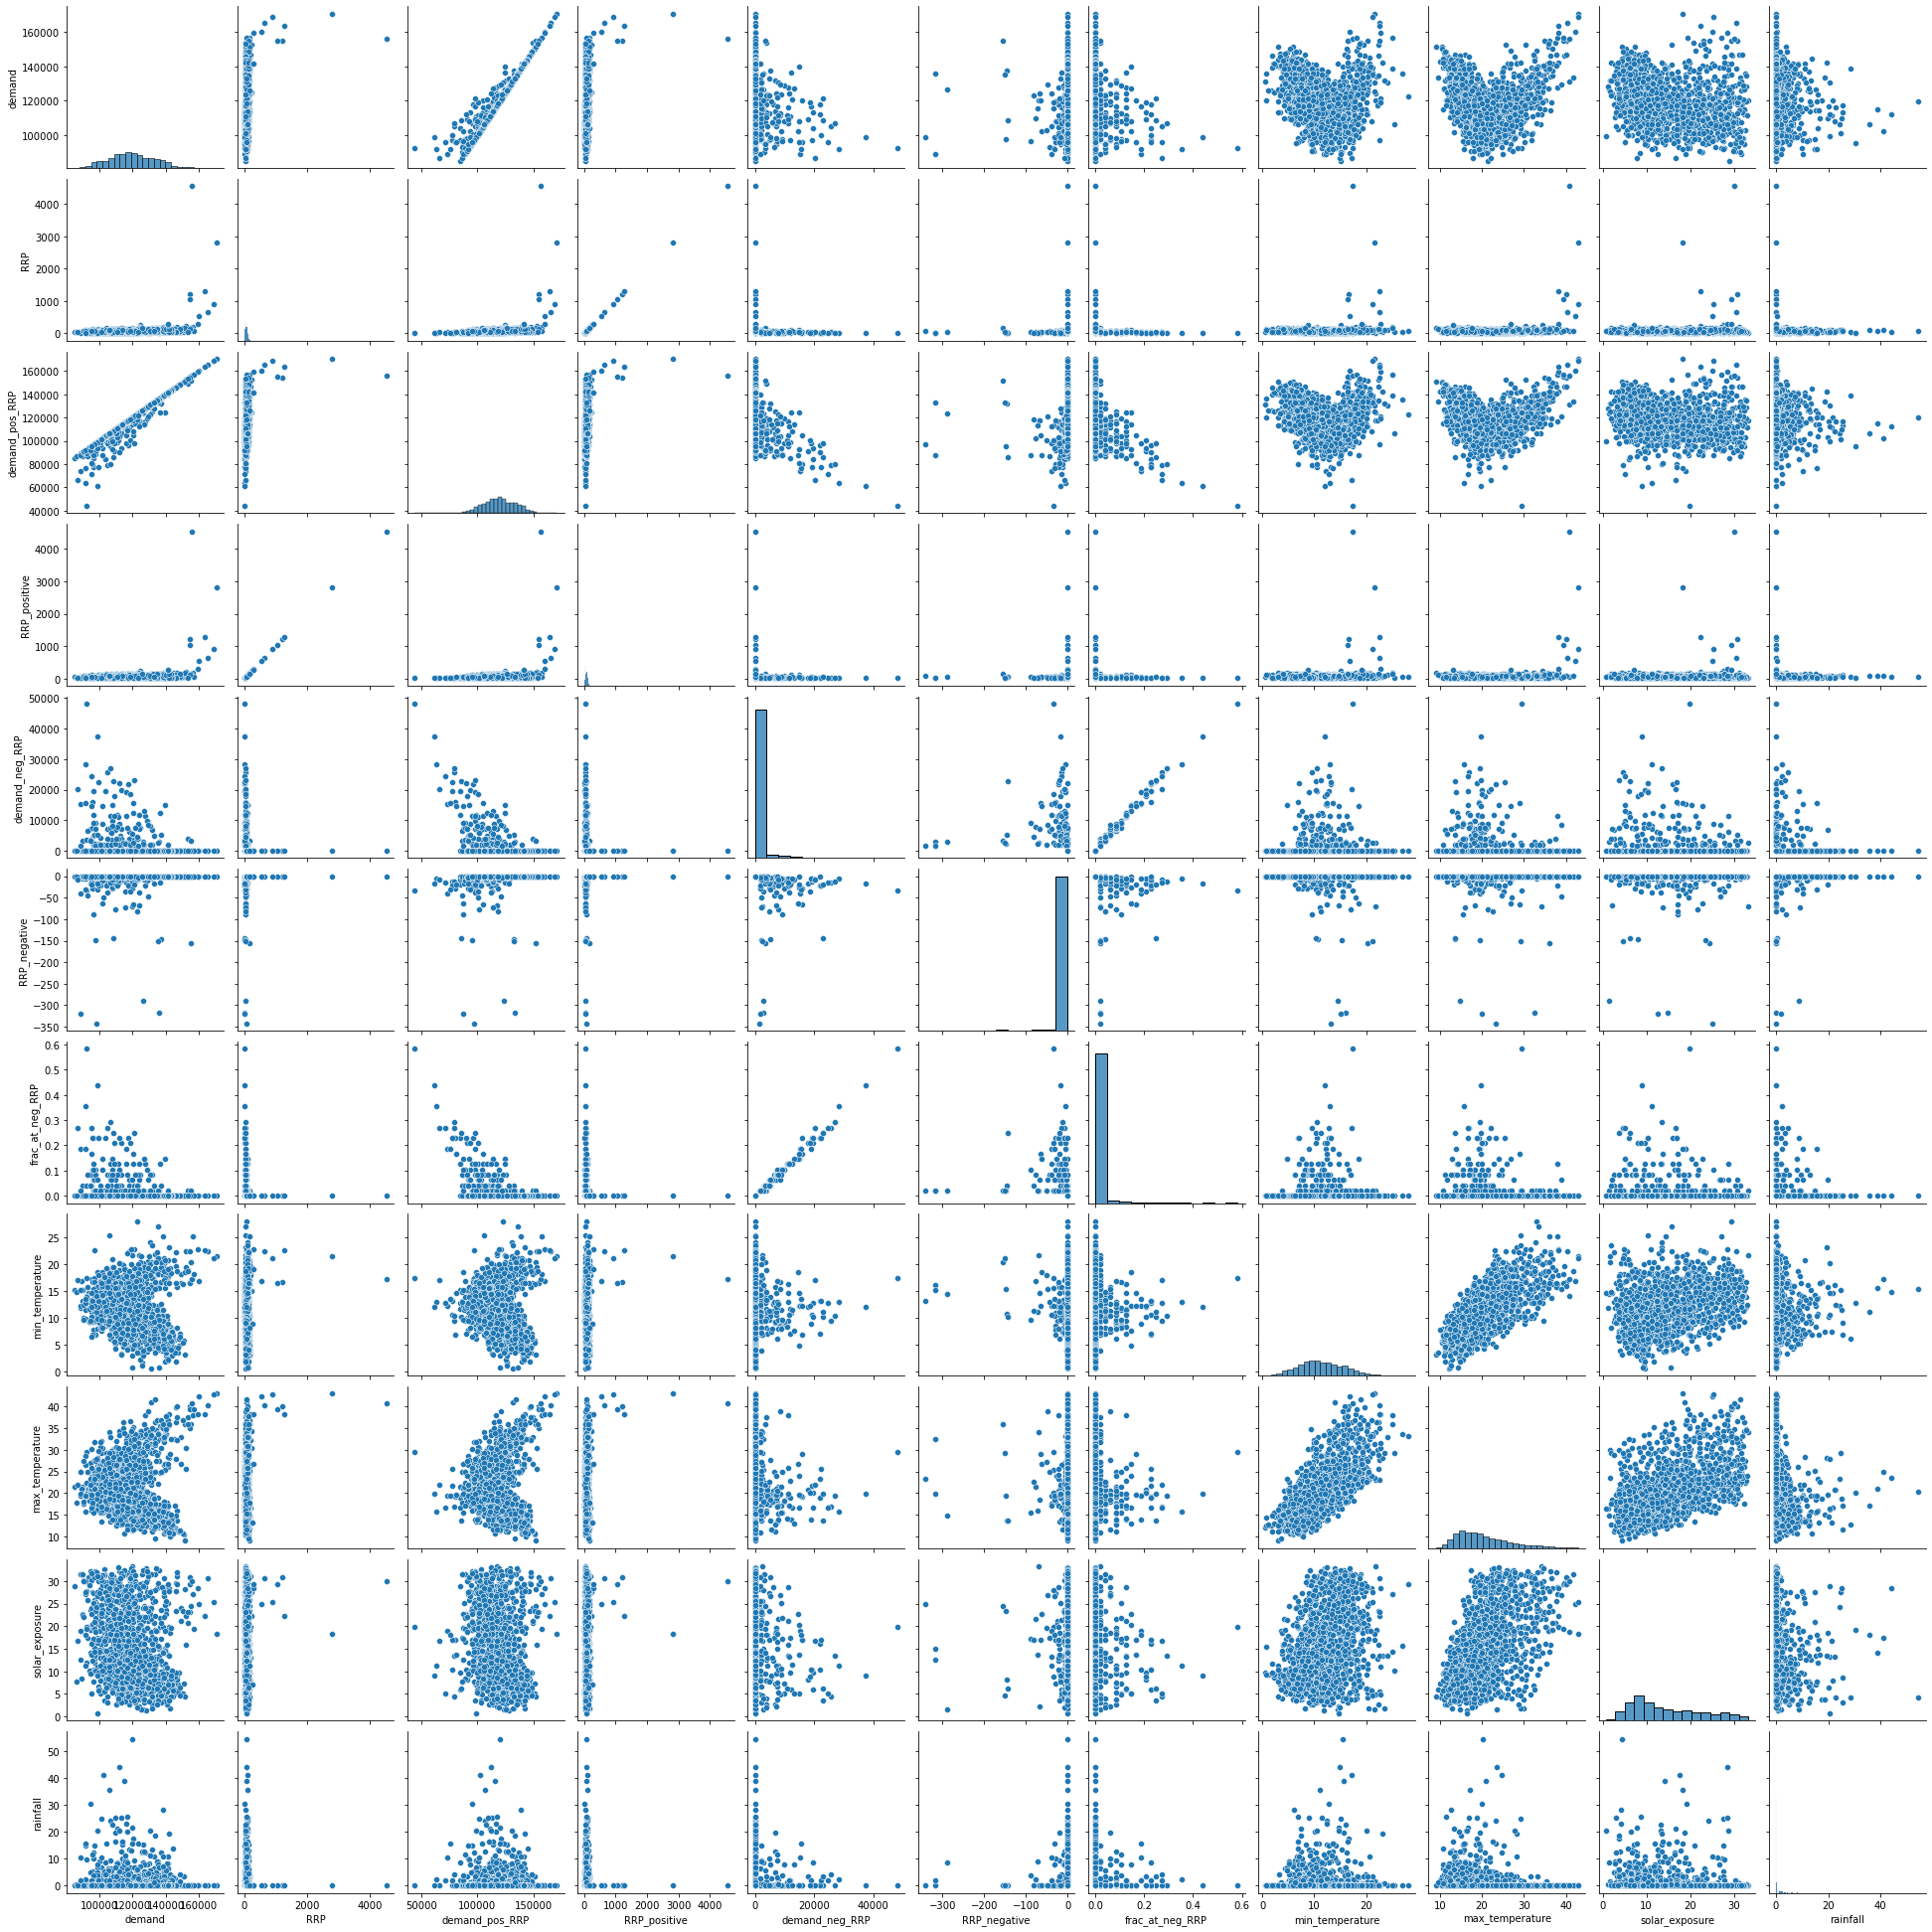

In [73]:
sns.pairplot(train.drop(columns=['date']), palette='viridis')
plt.show()

In [97]:
y = train['RRP']  # target
X = train.drop(columns=['RRP'])  # Features
X_num = X.select_dtypes(include=[float, int])

In [88]:
# Correlation between numerical variables

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["variabile"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

         variabile         VIF
0           demand         inf
1   demand_pos_RRP         inf
2     RRP_positive    1.331398
3   demand_neg_RRP         inf
4     RRP_negative    1.131705
5  frac_at_neg_RRP  122.930864
6  min_temperature   16.703973
7  max_temperature   34.160643
8   solar_exposure    6.856774
9         rainfall    1.156311


In [106]:
# Since we have collinearity let's employ Boruta for model selection

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)

# Fit Boruta
boruta.fit(X_num, y)

# Get the important features from Boruta
important_features = X_num.columns[boruta.support_]

X_boruta = X_num[important_features]

print("Features selezionate da Boruta:")
print(important_features)

Features selezionate da Boruta:
Index(['demand', 'demand_pos_RRP', 'RRP_positive', 'max_temperature'], dtype='object')


In [109]:
selected_features = []
for i in important_features:
    selected_features.append(i)
selected_features

['demand', 'demand_pos_RRP', 'RRP_positive', 'max_temperature']

In [118]:
print(train['school_day'].unique())
print(train['holiday'].unique())

['N' 'Y']
['N' 'Y']


In [125]:
X['holiday'] = X['holiday'].replace({'Y': 1, 'N': 0})
X['school_day'] = X['school_day'].replace({'Y': 1, 'N': 0})

In [260]:
#XGBoost on whole dataset (XGBoostW)

xgb_params = {
    'max_depth': [3,5,7,9,11,13,15],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params,
                              n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit XGBoost
xgb_random.fit(X.drop(columns=['date']), y)

# Prediction on test set
y_pred_xgb_tot = xgb_random.predict(X.drop(columns=['date']))
print("\nXGBoost Results:")
print("Best parameters:", xgb_random.best_params_)
print("Best score:", xgb_random.best_score_)
rmse_xgbt = np.sqrt(mean_squared_error(y, y_pred_xgb_tot))
print("RMSE:", rmse_xgbt)



XGBoost Results:
Best parameters: {'subsample': 0.8, 'n_estimators': 30, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0}
Best score: 0.7344853844577848
RMSE: 87.04179671370984


In [261]:
y_test = test['RRP']  
X_test = test.drop(columns=['RRP'])  
X_num_test = X.select_dtypes(include=[float, int])

In [262]:
X_test['holiday'] = X_test['holiday'].replace({'Y': 1, 'N': 0})
X_test['school_day'] = X_test['school_day'].replace({'Y': 1, 'N': 0})

In [264]:
# OVERFITTING XGBOOST on whole

y_train_pred = xgb_random.predict(X.drop(columns=['date']))
ase_train = np.mean(np.abs(y - y_train_pred) ** 2)
print(f"ASE on training data: {ase_train}")

y_test_pred = xgb_random.predict(X_test.drop(columns=['date']))
ase_test = np.mean(np.abs(y_test - y_test_pred) ** 2)
print(f"ASE on test data: {ase_test}")

overfitting_xgb = ((ase_train - ase_test)/ase_train)*100 
print(f'\n Overfitting value XGBoost: {round(overfitting_xgb,4)}') 

ASE sui dati di training: 7576.274375150795
ASE sui dati di test: 646.541174418382

Valore overfitting XGBoost tutte: 91.4662


In [265]:
# XGBoost only on modelselcted boruta variables

xgb_params = {
    'max_depth': [3,5,7,9,11,13,15],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params,
                              n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit XGBoost
xgb_random.fit(X_boruta, y)

# Prediction on test set
y_pred_xgb_ms = xgb_random.predict(X_boruta)
print("\nXGBoost Results:")
print("Best parameters:", xgb_random.best_params_)
print("Best score:", xgb_random.best_score_)
rmse_xgbms = np.sqrt(mean_squared_error(y, y_pred_xgb_ms))
print("RMSE:", rmse_xgbms)


XGBoost Results:
Best parameters: {'subsample': 0.8, 'n_estimators': 30, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0}
Best score: 0.7386194695133607
RMSE: 87.13168053134507


In [152]:
X_test_boruta = X_test[selected_features]

In [266]:
# OVERFITTING XGBOOST on modelselected subset

y_train_pred_ms = xgb_random.predict(X_boruta)
ase_train_ms = np.mean(np.abs(y - y_train_pred_ms) ** 2)
print(f"ASE on training data: {ase_train_ms}")

y_test_pred_ms = xgb_random.predict(X_test_boruta)
ase_test_ms = np.mean(np.abs(y_test - y_test_pred_ms) ** 2)
print(f"ASE on test data: {ase_test_ms}")

overfitting_xgbms = ((ase_train_ms - ase_test_ms)/ase_train_ms)*100 
print(f'\n Overfitting value XGBoost ms: {round(overfitting_xgbms,4)}') 


ASE sui dati di training: 7591.929752216372
ASE sui dati di test: 720.0107749325458

Valore overfitting XGBoost ms: 90.5161


In [267]:
# RFW

# Random Forest with Random Search
rf_params = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_params,
                             n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit Random Forest
rf_random.fit(X.drop(columns=['date']), y)

# Prediction on test set
y_pred_rf_tot = rf_random.predict(X.drop(columns=['date']))
print("\nRandom Forest Results:")
print("Best parameters:", rf_random.best_params_)
print("Best score:", rf_random.best_score_)

rmse_rft = np.sqrt(mean_squared_error(y, y_pred_rf_tot))
print("RMSE:", rmse_rft)


Random Forest Results:
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': False}
Best score: 0.8597994835207186
RMSE: 33.846659689812164


In [268]:
#Overfitting rfw

y_train_pred_rf = rf_random.predict(X.drop(columns=['date']))
ase_train_rf = np.mean(np.abs(y_train - y_train_pred_rf) ** 2)
print(f"ASE on training data: {ase_train_rf}")

y_test_pred_rf = rf_random.predict(X_test.drop(columns=['date']))
ase_test_rf = np.mean(np.abs(y_test - y_test_pred_rf) ** 2)
print(f"ASE test data: {ase_test_rf}")

overfitting_rf = ((ase_train_rf - ase_test_rf)/ase_train_rf)*100 
print(f'\n Overfitting value Random Forest: {round(abs(overfitting_rf),4)}') 

ASE sui dati di training: 1145.5963721579553
ASE sui dati di test: 95.25470835140075

Valore overfitting Random Forest: 91.6851


In [269]:
# RF on ms

# Random Forest with Random Search
rf_params = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_params,
                             n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit Random Forest
rf_random.fit(X_boruta, y)

# Prediction on test set
y_pred_rf_ms = rf_random.predict(X_boruta)
print("\nRandom Forest Results:")
print("Best parameters:", rf_random.best_params_)
print("Best score:", rf_random.best_score_)

rmse_rfms = np.sqrt(mean_squared_error(y, y_pred_rf_ms))
print("RMSE:", rmse_rfms)


Random Forest Results:
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': False}
Best score: 0.8597994835207187
RMSE: 33.846659689812164


In [270]:
#Overfitting rf ms

y_train_pred_rf_ms = rf_random.predict(X_boruta)
ase_train_rf_ms = np.mean(np.abs(y_train - y_train_pred_rf_ms) ** 2)
print(f"ASE on training data: {ase_train_rf_ms}")

y_test_pred_rf_ms = rf_random.predict(X_test_boruta)
ase_test_rf_ms = np.mean(np.abs(y_test - y_test_pred_rf_ms) ** 2)
print(f"ASE on test data: {ase_test_rf_ms}")

overfitting_rf_ms = ((ase_train_rf_ms - ase_test_rf_ms)/ase_train_rf_ms)*100 
print(f'\n Overfitting value Random Forest ms: {round(abs(overfitting_rf_ms),4)}') 

ASE sui dati di training: 1145.5963721579553
ASE sui dati di test: 95.25470835140077

Valore overfitting Random Forest ms: 91.6851


In [271]:
# MLPW

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.drop(columns=['date']))
X_test_scaled = scaler.transform(X_test.drop(columns=['date']))

mlp = MLPRegressor(hidden_layer_sizes=(250),  
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42)

mlp.fit(X_train_scaled, y)

# Predictions
y_pred = mlp.predict(X_test_scaled)

rmse_mlpt = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse_mlpt:.2f}")

RMSE: 49.22


In [251]:
#Overfitting MLPW

y_train_pred_mlp = mlp.predict(X_train_scaled)
ase_train_mlp = np.mean((y_train - y_train_pred_mlp) ** 2)
print(f"ASE on training data (MLP): {ase_train_mlp:.4f}")

# Predizioni su test
y_test_pred_mlp = mlp.predict(X_test_scaled)
ase_test_mlp = np.mean((y_test - y_test_pred_mlp) ** 2)
print(f"ASE on test data (MLP): {ase_test_mlp:.4f}")

# Calcolo overfitting
overfitting_mlp = ((ase_train_mlp - ase_test_mlp) / ase_train_mlp) * 100
print(f"\n Overfitting value MLP: {round(abs(overfitting_mlp), 4)}")


ASE sui dati di training (MLP): 27.2956
ASE sui dati di test (MLP): 49.2205

Valore overfitting MLP tutte: 80.324


In [285]:
# MLP on ms

# Data standardization
scaler = StandardScaler()
X_train_scaled_ms = scaler.fit_transform(X_boruta)
X_test_scaled_ms = scaler.transform(X_test_boruta)

mlpms = MLPRegressor(hidden_layer_sizes=(250),  
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42)

mlpms.fit(X_train_scaled_ms, y)

y_pred_ms = mlpms.predict(X_test_scaled_ms)

rmse_mlpms = mean_squared_error(y_test, y_pred_ms)
print(f"RMSE: {rmse_mlpms:.2f}")

RMSE: 22.69


In [286]:
#Overfitting MLP on ms

y_train_pred_mlp_ms = mlp.predict(X_train_scaled_ms)
ase_train_mlp_ms = np.mean((y_train - y_train_pred_mlp_ms) ** 2)
print(f"ASE on training data (MLP): {ase_train_mlp_ms:.4f}")

# Predizioni su test
y_test_pred_mlp_ms = mlp.predict(X_test_scaled_ms)
ase_test_mlp_ms = np.mean((y_test - y_test_pred_mlp_ms) ** 2)
print(f"ASE on test data (MLP): {ase_test_mlp_ms:.4f}")

# Calcolo overfitting
overfitting_mlp_ms = ((ase_train_mlp_ms - ase_test_mlp_ms) / ase_train_mlp_ms) * 100
print(f"\n Overfitting value MLP ms: {round(abs(overfitting_mlp_ms), 4)}")


ASE sui dati di training (MLP): 20.4686
ASE sui dati di test (MLP): 22.6908

Valore overfitting MLP ms: 10.8567


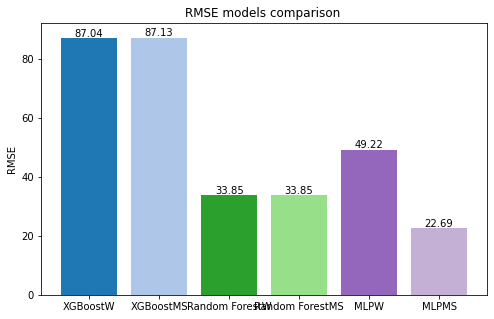

In [306]:
# RMSE plot

models = ['XGBoostW', 'XGBoostMS', 'Random ForestW', 'Random ForestMS', 'MLPW', 'MLPMS']
rmse = [rmse_xgbt, rmse_xgbms, rmse_rft, rmse_rfms, rmse_mlpt, rmse_mlpms]

# Barplot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse, color=['#1f77b4', '#aec7e8', '#2ca02c', '#98df8a', '#9467bd', '#c5b0d5'])
plt.ylabel('RMSE')
plt.title('RMSE models comparison ')
plt.ylim(0, max(rmse) + 5)

# Values labels
for i, v in enumerate(rmse):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.show()


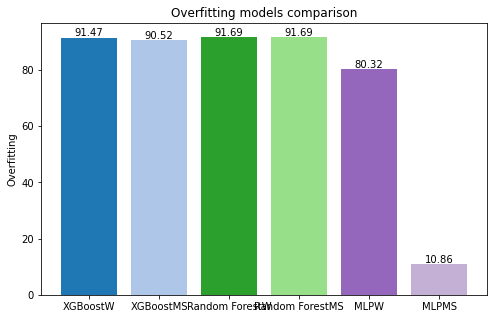

In [284]:
# Overfitting plot

models = ['XGBoostW', 'XGBoostMS', 'Random ForestW', 'Random ForestMS', 'MLPW', 'MLPMS']
over = [overfitting_xgb, overfitting_xgbms, overfitting_rf, overfitting_rf_ms, abs(overfitting_mlp), abs(overfitting_mlp_ms)]

# Barplot
plt.figure(figsize=(8, 5))
plt.bar(models, over, color=['#1f77b4', '#aec7e8', '#2ca02c', '#98df8a', '#9467bd', '#c5b0d5'])
plt.ylabel('Overfitting')
plt.title('Overfitting models comparison')
plt.ylim(0, max(over) + 5)

# Values lables
for i, v in enumerate(over):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.show()

####  We can assume that the best model is MLP employed on a dataset on which model selection and scaling were applied

In [289]:
# Predictions mlp

y_pred_mlpms = mlpms.predict(X_test_scaled_ms)

In [303]:
data = {
    'Actual test value' : test['RRP'],
    'Predicted values' : y_pred_mlpms, 
    'Prediction error' : (test['RRP']-y_pred_mlpms)
}

df_comp = pd.DataFrame(data)
print(df_comp)

      Actual test value  Predicted values  Prediction error
1433          92.945549         91.722988          1.222561
342           49.737006         47.814045          1.922961
984           86.685578         86.683750          0.001828
2008          33.158432         32.123145          1.035287
1343         111.540754        113.492469         -1.951716
...                 ...               ...               ...
1100          90.828170         90.732630          0.095540
15            23.015191         20.638264          2.376927
806           70.746073         70.889061         -0.142988
1001          61.649557         62.947774         -1.298217
1673          98.967006         98.875366          0.091639

[632 rows x 3 columns]


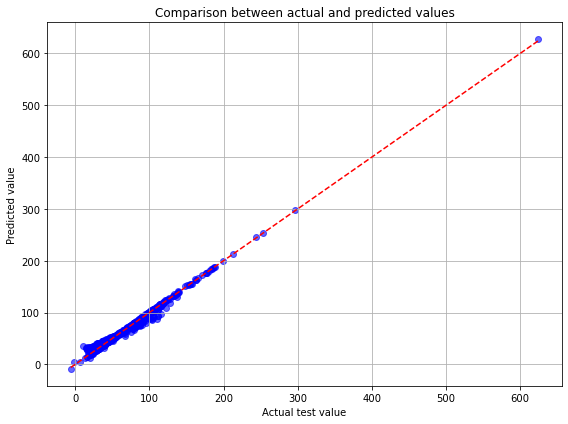

In [298]:
# Scatterplot comparison

plt.figure(figsize=(8,6))
plt.scatter(df_comp['Actual test value'], df_comp['Predicted values'], color='blue', alpha=0.6)
plt.plot([df_comp['Actual test value'].min(), df_comp['Actual test value'].max()],
         [df_comp['Actual test value'].min(), df_comp['Actual test value'].max()],
         color='red', linestyle='--')  # linea y=x
plt.xlabel('Actual test value')
plt.ylabel('Predicted value')
plt.title('Comparison between actual and predicted values')
plt.grid(True)
plt.tight_layout()
plt.show()

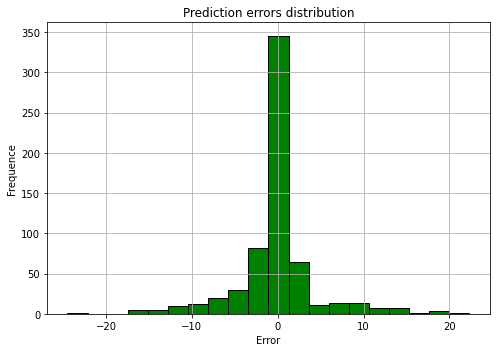

In [304]:
# Errors distribution

plt.figure(figsize=(7,5))
plt.hist(df_comp['Prediction error'], bins=20, color='green', edgecolor='black')
plt.title('Prediction errors distribution')
plt.xlabel('Error')
plt.ylabel('Frequence')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Excellent model that tends to underestimate a little more than overestimate, however it mainly predicts very well

### XAI